# Restricted Boltzmann Machine
##### MNIST reconstruction using tensorflow

Import dependencies

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
%matplotlib inline

### Util functions

function to plot the images after during testing phase

In [2]:
def plot_images(images, title, no_i_x, no_i_y=2):
    fig = plt.figure(figsize=(5, 15))
    fig.canvas.set_window_title(title)
    images = np.array(images).reshape(-1, 28, 28)
    for i in range(no_i_x):
        for j in range(no_i_y):
            ax = fig.add_subplot(no_i_x, no_i_y, no_i_x * j + (i + 1))
            ax.matshow(images[no_i_x * j + i], cmap="gray")
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))

            if j == 0 and i == 0:
                ax.set_title("Real")
            elif j == 0 and i == 1:
                ax.set_title("Reconstructed")

load the mnist dataset from tensorflow.examples

In [3]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
features_train, labels_train, features_test, labels_test = \
    mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Neural Network Model

<br>Hyper-parameters

In [4]:
n_input_layer = features_train.shape[1]
n_hidden_layer = 500

learning_rate = 1.0

n_epoch = 10
batch_size = 100

test_disp = 10  # no of images in plot

Placeholders

In [5]:
X = tf.placeholder(tf.float32, [None, n_input_layer])
W = tf.placeholder(tf.float32, [n_input_layer, n_hidden_layer])
B = tf.placeholder(tf.float32, [n_hidden_layer])
C = tf.placeholder(tf.float32, [n_input_layer])

function to get random sample from input

In [6]:
def get_sample(inp):
    distr = tf.random_uniform(shape=tf.shape(inp))
    sample = tf.nn.relu(tf.sign(inp - distr))
    return sample

#### Model (Training)
using contrastive-divergence-k(k = 1)

In [7]:
# Forward pass
p_h = tf.nn.sigmoid(tf.add(tf.matmul(X, W), B))
s_h = get_sample(p_h)

# Backward pass
p_v = tf.nn.sigmoid(tf.add(tf.matmul(s_h, tf.transpose(W)), C))
s_v = get_sample(p_v)

p_h1 = tf.nn.sigmoid(tf.add(tf.matmul(s_v, W), B))

# Error function
error = 0.5 * tf.reduce_mean(tf.square(tf.subtract(s_v, X)))

# Positive phase grad
p_w_change = tf.matmul(tf.transpose(X), s_h)

# Negative phase grad
n_w_change = tf.matmul(tf.transpose(s_v), p_h1)

contr_div = tf.subtract(p_w_change, n_w_change) / tf.to_float(tf.shape(X)[0])

change_w = contr_div
change_c = tf.reduce_mean(tf.subtract(X, s_v), 0)
change_b = tf.reduce_mean(tf.subtract(s_h, p_h1), 0)

# Adjust Weights
new_W = W + learning_rate * change_w
new_B = B + learning_rate * change_b
new_C = C + learning_rate * change_c

#### Model (Reconstruction)

In [8]:
hid = tf.nn.sigmoid(tf.add(tf.matmul(X, W), B))
rc = tf.nn.sigmoid(tf.add(tf.matmul(hid, tf.transpose(W)), C))

### Train Neural Network

Initialize random  Weights and biases

In [9]:
w = np.random.uniform(0.1, size=(n_input_layer, n_hidden_layer))
b = np.random.uniform(0.1, size=n_hidden_layer)
c = np.random.uniform(0.1, size=n_input_layer)

split into batches

In [10]:
n_batch = features_train.shape[0] // batch_size
batched_data = np.split(features_train, n_batch)

#### Start session

In [11]:
disp_imgs = []

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    print("*********** Train ***********")

    # Epoch-training
    for epoch in range(n_epoch):
        err = []

        # Batch training
        for b_idx in range(n_batch):
            e, w, b, c = sess.run([error, new_W, new_B, new_C], feed_dict={
                X: batched_data[b_idx], W: w, B: b, C: c})

            err.append(e)

        print("Epoch: %d, Error: %.8f" % (epoch, sum(err) / len(err)))

    # Reconstruction
    for i_no in range(test_disp):
        reconstd_image = rc.eval({X: features_test[i_no].reshape(1, -1), W: w, B: b, C: c})
        disp_imgs.extend(features_test[i_no])
        disp_imgs.extend(reconstd_image.reshape(-1))

*********** Train ***********
Epoch: 0, Error: 0.04789386
Epoch: 1, Error: 0.03652624
Epoch: 2, Error: 0.03318628
Epoch: 3, Error: 0.03103307
Epoch: 4, Error: 0.02963336
Epoch: 5, Error: 0.02865732
Epoch: 6, Error: 0.02790888
Epoch: 7, Error: 0.02735087
Epoch: 8, Error: 0.02691417
Epoch: 9, Error: 0.02654817


#### plot output

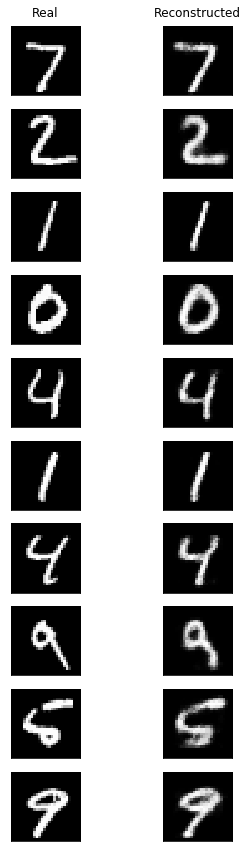

In [12]:
plot_images(disp_imgs, "Restricted Boltzmann Machine", test_disp)
plt.show()